# Descripción.

Felicidades! Eres el orgulloso propietario de 5 robots nuevos y un almacén lleno de cajas. El dueño anterior del almacén lo dejó en completo desorden, por lo que depende de tus robots organizar las cajas en algo parecido al orden y convertirlo en un negocio exitoso.

Cada robot está equipado con ruedas omnidireccionales y, por lo tanto, puede conducir en las cuatro direcciones. Pueden recoger cajas en celdas de cuadrícula adyacentes con sus manipuladores, luego llevarlas a otra ubicación e incluso construir pilas de hasta cinco cajas. Todos los robots están equipados con la tecnología de sensores más nueva que les permite recibir datos de sensores de las cuatro celdas adyacentes. Por tanto, es fácil distinguir si un campo está libre, es una pared, contiene una pila de cajas (y cuantas cajas hay en la pila) o está ocupado por otro robot. Los robots también tienen sensores de presión equipados que les indican si llevan una caja en ese momento.

Lamentablemente, tu presupuesto resultó insuficiente para adquirir un software de gestión de agentes múltiples de última generación. Pero eso no debería ser un gran problema ... ¿verdad? Tu tarea es enseñar a sus robots cómo ordenar su almacén. La organización de los agentes depende de ti, siempre que todas las cajas terminen en pilas ordenadas de cinco.


#### Nombre: Olimpia Helena García Huerta
#### Matricula: A01708462

In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

from mesa.space import MultiGrid
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Importamos la libreria para generar numeros aleatorios
import random

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time as tm
import datetime

In [2]:
## Definimos la clase RobotAgent
class RobotAgent(Agent):
    def __init__ (self, id, model, seed=67890):
        super(). __init__ (id, model)
        self.carga = False
        self.random.seed(seed)
  
    ## Definimos el método step  
    def step(self):
        self.eleccion()
        ##print("step")
    
    ##Definimos el método move, el cual se encarga de mover al agente a una celda vacía.
    def move(self):
        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)
        
        ## Creamos una lista de celdas vacías
        celdas_vacias = []
        for neighbor in neighbors:
            if self.model.grid.is_cell_empty(neighbor):
                celdas_vacias.append(neighbor)
        ## Si hay celdas vacías, el agente se mueve a una de ellas
        if celdas_vacias:
            nueva_posicion = self.random.choice(celdas_vacias)
            self.model.grid.move_agent(self, nueva_posicion)

    ## Definimos el método tomar_carga, el cual se encarga de tomar una carga de una celda.
    def tomar_carga(self):
        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)

        for neighbor in neighbors:
            x, y = neighbor
            if 0 < self.model.piso[x, y] < 5:
                self.model.piso[x, y] -= 1
                self.carga = True
                break
        self.move()
    
    ## Definimos el método dejar_carga, el cual se encarga de dejar una carga en una celda.   
    def dejar_carga(self):
        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)

        for neighbor in neighbors:
            x, y = neighbor
            if 0 < self.model.piso[x, y] < 5:
                self.model.piso[x, y] += 1
                self.carga = False
                break
        self.move()

    ## Definimos el método contador, el cual se encarga de contar el número de celdas con stakcs.
    def contador(self):
        stacks = 0
        for x in range(self.model.piso.shape[0]):
            for y in range(self.model.piso.shape[1]):
                if self.model.piso[x, y] == 5:
                    stacks += 1
        return stacks

    ## Definimos el método eleccion, el cual se encarga de elegir si tomar o dejar una carga.    
    def eleccion(self):
        contador = 40 - self.contador()

        if not self.carga:
            self.tomar_carga()
            
        else:
            self.dejar_carga()
        
        ##Definimos que pasa cuando queda un stack en el piso
        if contador == 1 and self.carga == False:
            neighbors = self.model.grid.get_neighborhood(
                self.pos, moore=False, include_center=False)

            for neighbor in neighbors:
                x, y = neighbor
                if 0 < self.model.piso[x, y] == 1:
                    self.model.piso[x, y] -= 1
                    self.carga = True
                    break
            self.move()
        


In [3]:
## Definimos la clase RobotModel
class RobotModel(Model):
    def __init__(self, width, height, robots, cajas,seed=67890):
        self.grid = SingleGrid(width, height, False)
        self.schedule = RandomActivation(self)

        ##Inicializamos suelo + cajas
        self.width = width
        self.height = height
        self.num_cajas = cajas     
        random.seed(seed)
        
        ##inicializamos el suelo
        self.piso = np.zeros((self.width, self.height))
        
        ##llenamos de cajas el piso de manera aleatoria
        total_cajas = 0
        while total_cajas < self.num_cajas:
            valor = random.randint(1, 3)
            remaining_boxes = self.num_cajas - total_cajas
            valor = min(valor, remaining_boxes)

            x, y = random.randint(0, self.width - 1), random.randint(0, self.height - 1)

            if self.piso[x, y] == 0:
                self.piso[x, y] = valor
                total_cajas += valor
        
        print( "cajas:",  total_cajas)
        ##print (self.piso)
        
        ##funcion para crear agentes
        for i in range (robots):
            agent = RobotAgent(i, self)
            self.schedule.add(agent)

            ##ubicamos a los agentes en el grid
            empty_cell_found = False
            while not empty_cell_found:
                x, y = self.random.randint(0, self.width), self.random.randint(0, self.height)
                if self.grid.is_cell_empty((x, y)):
                    self.grid.place_agent(agent, (x, y))
                    empty_cell_found = True

        ##datacollector
        self.datacollector = DataCollector(
            model_reporters={"Floor": self.piso_ini ,"Final_Floor": self.piso_info, "Agents": self.agent_info})
        

    ##funcion para guardar el piso inicial
    def piso_ini(self): 
        return self.piso.copy()
    
    ##almacenamos la info del piso final
    def piso_info(self):
        piso_info = self.piso
        return piso_info
        
    ##almacenamos la info de los agentes
    def agent_info(self):
        agent_info = np.zeros((self.width, self.height))

        for agent in self.schedule.agents:
            x, y = agent.pos
            agent_info[x, y] = 1
        return agent_info

    ##funcion para correr el modelo
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

    

In [4]:
##variables
width = 20
height = 20
robots = 5
cajas = 200
iteraciones = 1000000

##inicializamos el modelo
model = RobotModel(width, height, robots, cajas)

##contador de iteraciones
it_total = 0

##iniciar tiempo de ejecucion
start = tm.time()

##recorrer el modelo
for i in range (iteraciones):
    model.step()
    it_total += 1
    num = 0

    ##condicion de paro cuando hayan 5 cajas stackeadas    
    for i in range (width):
        for j in range (height):
            if model.piso[i][j] == 5:
                num += 1
    if num == 40:
        break

    ##condicion de paro cuando hayan pasado 5 minutos
    if (tm.time() - start) > 300:
        break


##finalizar contador de tiempo
end = tm.time()

##tiempo de ejecucion
execution_time = float(end - start)

##iteraciones totales
print("Total de iteraciones para limpiar el espacio: ", it_total)




cajas: 200
Total de iteraciones para limpiar el espacio:  208392


In [40]:
#Obtener los dats de la simulacion
all_grids = model.datacollector.get_model_vars_dataframe()

#Obtener los datos del piso y de los agentes
piso = all_grids.get("Floor")
agentes = all_grids.get("Agents")



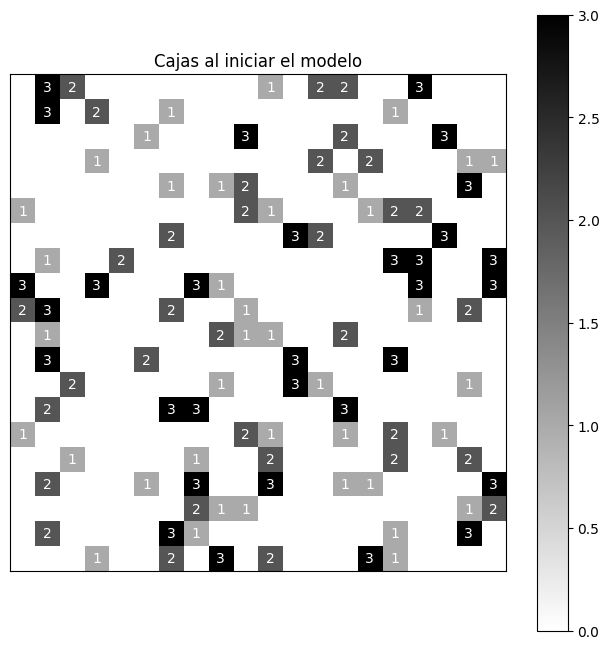

In [41]:
# graficar el piso inicial
fig, axis = plt.subplots(figsize=(8, 8))
axis.set_xticks([])
axis.set_yticks([])

plt.imshow(piso[0], cmap=plt.cm.binary, interpolation='nearest')

plt.colorbar()
plt.close()

# graficar un mapa de calor de la simulacion
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(piso[0], cmap=plt.cm.binary, interpolation='nearest')

##ejes sin nombre 
ax.set_xticks([])
ax.set_yticks([])

# titulo
ax.set_title("Cajas al iniciar el modelo")

# Agregar texto a cada celda
for i in range(20):
    for j in range(20):
        text = ax.text(j, i, int(piso[0][i, j]),
                       ha="center", va="center", color="w")

##añadir grid
ax.grid(True, color="b", linestyle='--', linewidth=0.5)

fig.colorbar(im)
plt.show()

In [42]:
##info para graficar
datos_graficables = all_grids.get("Floor") + 10 * all_grids.get("Agents")

In [43]:
# Graficar los frames de la simulación del escenario 1
fig, axis = plt.subplots(figsize = (3,3))
axis.set_xticks([])
axis.set_yticks([])


# Animar los frames de la simulación
iter = len(all_grids)
steps = max(1, int(iter // 2000))
datos = datos_graficables.iloc[::steps].reset_index(drop=True)
agentes = agentes.iloc[::steps].reset_index(drop=True)

patch = plt.imshow(datos_graficables[0], cmap=plt.cm.binary)

##funcion para animar
def animate(i):
    patch.set_data(datos_graficables[i])
    

# Crear la animación
anim = animation.FuncAnimation(fig, animate, frames= len(datos_graficables))

plt.close()

In [ ]:
anim

In [45]:
##obtener la ifromacion del piso final
piso_final = all_grids.get("Final_Floor")

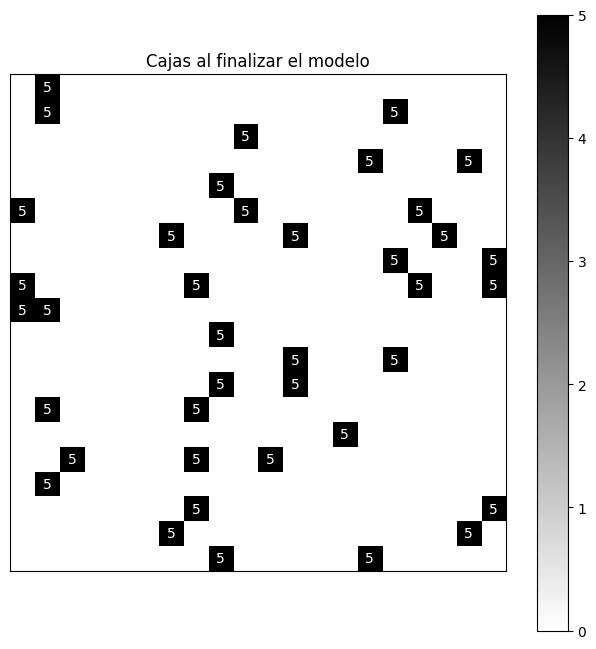

In [46]:
##graficar piso final
fig, axis = plt.subplots(figsize=(8, 8))
axis.set_xticks([])
axis.set_yticks([])

plt.imshow(piso_final[0], cmap=plt.cm.binary, interpolation='nearest')

plt.colorbar()
plt.close()

# graficar un mapa de calor de la simulacion
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(piso_final[0], cmap=plt.cm.binary, interpolation='nearest')

##ejes sin nombre 
ax.set_xticks([])
ax.set_yticks([])

# titulo
ax.set_title("Cajas al finalizar el modelo")

# Agregar texto a cada celda
for i in range(20):
    for j in range(20):
        text = ax.text(j, i, int(piso_final[0][i, j]),
                       ha="center", va="center", color="w")

##añadir grid
ax.grid(True, color="b", linestyle='--', linewidth=0.5)

fig.colorbar(im)
plt.show()

## Descripción:
Para la resolución de este problema, despues de llenar la cuadricula de cajas, nos centramos en el movimiento de los agentes.
En cada step tenian que tomar la decisión de tomar/dejar una caja. Dependiendo del contenido de la celda y si el robot tenía ya una caja en sus manos, hasta tener el espacio con cajas stackeadas.

Se hizo uso de la clase Agente y Moelo para dar solución a este problema.

##### ¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?

Es posible agilizar este proceso implementando algortimos y no a fuerza bruta como yo lo resolvi.
Por ejemplo, podríamos de primeras escanear el espacio con los agentes para buscar las pilas que tengan más cajas y marcarlas, posteriormente las cajas que esten solas llevarlas a las posiciones donde hay más cajas. Usando un algoritmo para encontrar el camino más corto hacia alla, (como dikstra o Floyd), cuidando siempre de avisar a los demás agentes del movimiento realizado y las pilas que encontramos.


## Conclusión:
Este ejericicio me ayudó  a entender mejor el como se implemntentan los sistemas multiganetes en un problema de la vida real, además de que me prepara para la implementación final del proyecto.
Y ejemplifica la necesidad de no hacer soluciones a fuerza bruta, sino crear algortimos y soluciones que optimicen recursos.